In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
import numpy as np
import librosa
import os


In [2]:
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet')

In [3]:
def load_audio_from_directory(directory_path, num_files=None, max_len=16000):
    audio_files = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)

            # Uzunluğu sabitle (padding veya truncate)
            if len(waveform) < max_len:
                waveform = np.pad(waveform, (0, max_len - len(waveform)), mode='constant')
            else:
                waveform = waveform[:max_len]

            audio_files.append(waveform)
    return audio_files






In [4]:
how_many = 1000

sick_audio_files = load_audio_from_directory('../data/data/Sick', how_many)
healthy_audio_files = load_audio_from_directory('../data/data/Healthy', how_many)
none_audio_files = load_audio_from_directory('../data/data/None', how_many)

In [5]:
import numpy as np

# Etiketler: Sick → 1, Healthy → 0, None → 2
X = np.array(sick_audio_files + healthy_audio_files + none_audio_files, dtype=np.float32)
y = np.array(
    [1] * len(sick_audio_files) + 
    [0] * len(healthy_audio_files) + 
    [2] * len(none_audio_files), 
    dtype=np.int32
)

print("X shape:", X.shape)  # (örnek_sayısı, örnek_uzunluğu)
print("y shape:", y.shape)  # (örnek_sayısı,)


X shape: (3000, 16000)
y shape: (3000,)


In [6]:
from sklearn.model_selection import train_test_split


# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:

def build_model():
    input_waveform = tf.keras.Input(shape=(None,), dtype=tf.float32, name='audio_input')

    def extract_yamnet_spectrogram(x):
        def _apply_yamnet(waveform):
            _, _, spectrogram = yamnet_layer(waveform)
            return spectrogram
        return tf.map_fn(_apply_yamnet, x, dtype=tf.float32)

    spectrograms = tf.keras.layers.Lambda(
        extract_yamnet_spectrogram,
        output_shape=(None, 64)  
    )(input_waveform)

    pooled = tf.keras.layers.GlobalAveragePooling1D()(spectrograms)

    x = layers.Dense(256, activation='relu')(pooled)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_waveform, outputs=output, name='yamnet_spec_model')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model




model = build_model()
model.summary()


Model: "yamnet_spec_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,411 (68.01 KB)

 Trainable params: 17,411 (68.01 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(X_train, y_train, epochs=25, shuffle=True,
          batch_size=16, validation_split=0.15)


Epoch 1/25
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.3466 - loss: 1.7228 - val_accuracy: 0.5306 - val_loss: 1.0209
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.4463 - loss: 1.0732 - val_accuracy: 0.4361 - val_loss: 1.0202
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.4747 - loss: 1.0261 - val_accuracy: 0.5083 - val_loss: 1.0204
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.4513 - loss: 1.0520 - val_accuracy: 0.4972 - val_loss: 1.0181
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.5132 - loss: 1.0221 - val_accuracy: 0.4750 - val_loss: 0.9929
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.4932 - loss: 1.0280 - val_accuracy: 0.5583 - val_loss: 0.9762
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.4879 - loss: 1.0159 - val_accuracy: 0.5806 - val_loss: 0.9809
Epoch 8/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.5224 - loss: 0.9992 - val_accu

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5743 - loss: 0.8890


In [10]:
y_pred_probs = model.predict(X_test)

# Eğer sınıf sayısı 2'den fazlaysa:
y_pred = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [11]:
from sklearn.metrics import accuracy_score


y_pred = np.argmax(y_pred_probs, axis=1)

# Doğruluk hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.5700


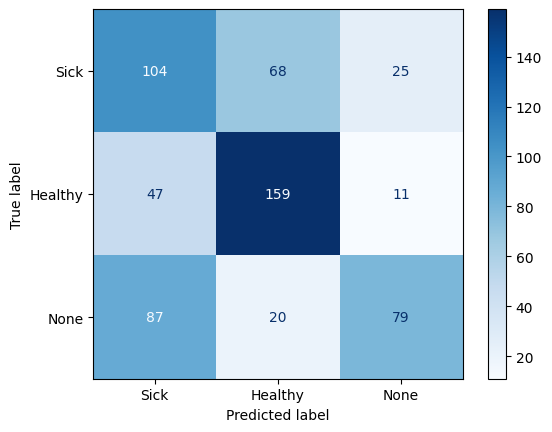

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')

In [13]:
from sklearn.metrics import classification_report
class_names = ["sick", "healthy", "none"]
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        sick       0.44      0.53      0.48       197
     healthy       0.64      0.73      0.69       217
        none       0.69      0.42      0.52       186

    accuracy                           0.57       600
   macro avg       0.59      0.56      0.56       600
weighted avg       0.59      0.57      0.57       600

